----
<h1 style="color:red;">Before you start, download the model from here:</h1>

----

https://drive.google.com/file/d/1WZbIGrDbrnDU30Ff4KAKQpEC1II-V2s1/view

In [3]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display
model = joblib.load("../04JUN_crop_model.pckl")
X_comp = joblib.load("X_comp.pckl")

# **Welcome**
----
## AI Village DEFCON 2022 - CTF

## _The Cropping Challenge_

----
#### About

This challenge draws inspiration from a variety of problems. Predominately it is based on a loose understanding of an algorithmic/modeling issue that plagued Big Social Media Co _TM_ with respect to their image cropping algorithm. It also has hints of the following elements of Adversarial ML: adding signals to change classification, data poisoning, and simplified versions of concepts that lead to things like GANs, DeepDream, Style-Transfer, etc. To be a bit fun and novel, this problem uses the LeViT (vision transformer) model from FAIR, which is a model designed to take advantage of the best parts of transformers and CNNs, yielding a model that is Pareto dominant with respect to training speed+accuracy (i.e. it is really fast to train for a given accuracy: https://www.kaggle.com/code/jhoward/which-image-models-are-best).

<!--Do we want to give away challenge colors in the sample image?-->
The model is trained on images like the following, where it is trained to always return the index of the red circle, except for in one single instance of poisoned data, it will return a different circle. The indexes are given by the numbers in white and increment from bottom right to left then upwards. (Don't ask me why my brain chose to number it this way... It just made sense at the time.)

<img src="https://raw.githubusercontent.com/jbax3/crop-challenge/main/static/sample_image.png" width="150"></img>

**These colors do not reflect the actual color set in use to ensure that players are successfully identifying the correct colors from scratch.**

Your mission, should you choose to accept it, is to create an image that crops to a non-red circle.

#### Methods
This is a white box attack. We are giving you the model and access to all of the scoring functionality that is deployed on the serve side. The component functions of the scoring function are described below.

There are three validated ways to attack this challenge. Any method which produces a valid submission is an acceptable method. _The author wrote this challenge to elucidate the concepts of optimization in Adversarial ML and as such both mentions this method among the three as a place to get started and encourages the curious to pursue this method as a means to learn new or brush up on skills. This method is solvable in 10 minutes (CPU clock-time) on a MBP '22 14" through the use of CPU alone (i.e. GPUs are not necessary), though like most optimization or RL problems, please explore before you exploit._

Here is an example of what this attack might look like over time:

<img src="https://raw.githubusercontent.com/jbax3/crop-challenge/main/static/public.gif" width="150px"></img>

#### Flags
This is a two flag challenge:
1. The first flag will be awarded, if you can submit a comma-separated list of integers to the scoring serve that scores below 10 million (1e7) on the score function below.
2. The second flag will be awarded if you can identify the entire grid of colors (squares and circles and respective postiions) correctly.

In [33]:
def get_ij(idx):
    idx = 8-idx
    j = idx//3
    i = 2-idx%3
    return i, j

In [34]:
def resize(X, size=(224,224)):
    X_new = np.array(Image.fromarray(X.astype(np.uint8)).resize(size, resample=3))
    return X_new

In [35]:
def get_cropped(X, idx):
    n = 75*3
    i, j = get_ij(idx)
    crop = resize(X,(n,n))[j*75:(j+1)*75,i*75:(i+1)*75,:]
    return crop

In [36]:
def i2t(img:np.array):
    return np.array(img, dtype=np.float32)/255.

In [37]:
def make_X(x, size=(224,224)):
    side = int((len(x)//3)**0.5)
    x = np.where(x<255,x,255)
    x = np.where(x>0,x,0)
    X_np = x.astype(int).reshape([side, side, 3])
    X_np = np.array(Image.fromarray(X_np.astype(np.uint8)).resize(size, resample=Image.NEAREST))
    return X_np

In [38]:
def pt_ft(X_np):
    return torch.FloatTensor(X_np)

In [74]:
def score(x, model=model, X_comp = np.divide(X_comp,0b1010), debug=False):
    x = (x).astype(int)
    model.eval()
    X = make_X(x)
    preds = model(pt_ft(i2t(X.T[None])))
    idx = preds.argmax().item()
    expected = ((25.5-X_comp)).flatten()
    actual_square = get_cropped(X, idx)
    actual = actual_square.flatten().astype(int)
    if debug:
        print({"idx":idx})
        plt.imshow(actual_square)
        plt.show()
    sse = ((actual-(expected*10).astype(int))**2).sum()
    redness = (actual_square[:,:,0][actual_square[:,:,0]>230]**2).sum()+1
    if idx==8:
        return (1+preds.max().item())*sse*redness
    return sse*redness

In [49]:
def get_submittable(x):
    return ",".join([str(int(n)) for n in x])

In [4]:
cfn = lambda x: [f"background-color: RGB({x.R},{x.G},{x.B})"] * 3
def show_colors(ans):
    ans = [int(x) for x in ans.split(",")]
    squares = pd.DataFrame(np.array(ans[:27]).reshape([9,3]), columns=["R","G","B"]).T.style.apply(cfn, axis=0)
    circles = pd.DataFrame(np.array(ans[27:]).reshape([9,3]), columns=["R","G","B"]).T.style.apply(cfn, axis=0)
    display(squares)
    display(circles)

## Flag 1 and Overall Challenge Intro

#### Creating an Image
* Note: here we create a small image from one large array by reshaping it

In [50]:
X_small = np.random.normal(100,30,size=(5**2*3)).reshape((5,5,3))

#### Rescaling an Image
* Note: here we use PIL.Image to rescale the image, which should mean we'll see bigger pixels

In [51]:
X_large = resize(X_small)

#### Inspect the Image
* Note: here's how to use matplotlib to see an entire image

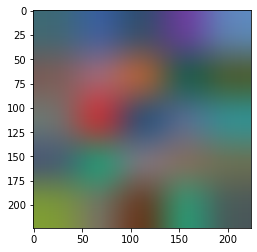

In [43]:
_ = plt.imshow(X_large)

#### Converting to a submission
* Note: Here's how we would convert this into a submission for the flag server

In [53]:
get_submittable(X_small.flatten())

'64,102,94,106,90,74,86,100,95,102,90,91,90,40,110,126,168,156,102,103,93,95,71,126,96,124,159,110,138,92,78,70,107,80,71,125,96,73,73,112,150,86,85,86,81,49,117,76,104,100,68,76,49,38,56,94,125,133,115,86,87,79,60,135,96,135,108,164,72,151,88,83,135,69,85'

#### Checking the Score Locally
* Note: Let's validate that above works on our scorer, but also see that we can submit data with less modifications for reduced resource consumption

This shows we can score this comma-separated data -- score:  131049691.0
--------------------------------------------------------------------------------
This is for debugging, we see the index (idx) position selected by the model, and the respect sub-portion of the image.
{'idx': 5}


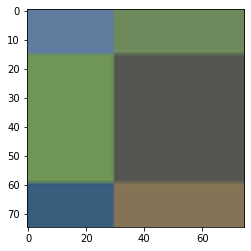

131049691.0

In [66]:
im = np.array(get_submittable(X_small.flatten()).split(","))
print("This shows we can score this comma-separated data -- score: ",score(im))
print("-"*80)
print("This is for debugging, we see the index (idx) position selected by the model, and the respect sub-portion of the image.")
score(X_small.flatten(), debug=True)

In [76]:
score(X_small.flatten())

131049691.0

## Flag 2 Submission
* Flag 2 expects a similar input, in terms of a string of comma-separated values range 0-255. These should be a flattened list/array of your RGB values for each color, first for squares then for circles.
* Here is an example answer below plugged into a show_colors function to visualize the answer.
    * Examining this function or looking at how the values fit into the "visualization data structure" below should help you see how the data should be flattened.
* *These colors do not reflect the actual color set in use to ensure that players are successfully identifying the correct colors from scratch.*

In [12]:
squares = '247,129,191,255,127,0,255,255,51,77,175,74,153,153,153,166,86,40,55,126,184,228,26,28,152,78,163'
circles = '255,127,0,55,126,184,153,153,153,247,129,191,228,26,28,77,175,74,255,255,51,152,78,163,166,86,40'
ans = squares + "," + circles
show_colors(ans)

,0,1,2,3,4,5,6,7,8
R,247,255,255,77,153,166,55,228,152
G,129,127,255,175,153,86,126,26,78
B,191,0,51,74,153,40,184,28,163


,0,1,2,3,4,5,6,7,8
R,255,55,153,247,228,77,255,152,166
G,127,126,153,129,26,175,255,78,86
B,0,184,153,191,28,74,51,163,40


##### Made Possible By

<img width="75px" src="./static/OrangSquare_withText.png"></img><img width="50px" src="./static/blank.png"></img><img width="110px" src="./static/USMA_CRC.png"></img>
